In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Check GPU

In [ ]:
!/opt/bin/nvidia-smi

ngpu= 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

Sat Mar 19 05:21:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Data

In [ ]:
ROOT = '.data'

batch_size = 64

# Grayscale
# transforms = torchvision.transforms.Compose([
#                            torchvision.transforms.ToTensor(),
#                            torchvision.transforms.Grayscale(num_output_channels=1)])

transforms_train = torchvision.transforms.Compose([
                           torchvision.transforms.RandomCrop(32, padding=4),
                           torchvision.transforms.RandomHorizontalFlip(),
                           torchvision.transforms.ToTensor()])

transforms_test = torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.CIFAR10(root = ROOT, 
                           train = True, 
                           download = True, 
                           transform = transforms_train)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = transforms_test)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data
Files already downloaded and verified


## Create Model

In [ ]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [8, 4, 8, 2])

## Model Summary

In [ ]:
from torchsummary import summary

net = project1_model().to(device)
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
      BatchNorm2d-14           [-1, 32,

## Train Parameter

In [ ]:
lr = 0.001
num_epochs = 1000

# optimizer = torch.optim.SGD(net.parameters(), lr=lr)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

loss = nn.CrossEntropyLoss().to(device)



## Train

In [ ]:
tr_loss = []
ts_loss = []
acc_list = []
acc_max = 0.935

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    # for i, (X, y) in enumerate(tqdm(trainloader)):
    for i, (X, y) in enumerate(trainloader):
        
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
    
      train_loss += l.item()
    
    net.eval()
    test_loss = 0
    acc_num = 0
    for i, (X_ts, y_ts) in enumerate(testloader):
      
      
      X_ts, y_ts = X_ts.to(device), y_ts.to(device)
      y_ts_hat = net(X_ts)
      l_ts = loss(y_ts_hat, y_ts)
      test_loss += l_ts.item()
      
      y_pred = torch.argmax(y_ts_hat,axis=1)
      acc_num += torch.sum(y_pred == y_ts)
    
    
    train_loss = train_loss*batch_size/len(train_data)
    test_loss = test_loss*batch_size/len(test_data)

    acc = acc_num/len(test_data)

    ts_loss.append(test_loss)
    tr_loss.append(train_loss)
    acc_list.append(acc)

    if epoch%10==0:
      print('Epoch %d, training loss is %f, testing loss is %f, acc is %f'%(epoch,train_loss,test_loss,acc))
    if acc >= acc_max:
      accuracy = acc.cpu().numpy()
      filename = '/content/drive/MyDrive/DL/project1/8482_bak/[8,4,8,2]_epoch' + str(epoch) + '_' + str(accuracy) + '.pt'
      torch.save(net, filename)
      acc_max = acc;
    # if acc > 0.94:
      # break
    
    

Epoch 0, training loss is 1.596008, testing loss is 1.422059, acc is 0.467100
Epoch 10, training loss is 0.372624, testing loss is 0.489481, acc is 0.836700
Epoch 20, training loss is 0.198137, testing loss is 0.338001, acc is 0.893000
Epoch 30, training loss is 0.113758, testing loss is 0.356243, acc is 0.903500
Epoch 40, training loss is 0.072042, testing loss is 0.401158, acc is 0.910100
Epoch 50, training loss is 0.054356, testing loss is 0.388552, acc is 0.915100
Epoch 60, training loss is 0.042997, testing loss is 0.418256, acc is 0.913800
Epoch 70, training loss is 0.036925, testing loss is 0.416604, acc is 0.920500
Epoch 80, training loss is 0.028839, testing loss is 0.416647, acc is 0.917800
Epoch 90, training loss is 0.024815, testing loss is 0.439279, acc is 0.922400
Epoch 100, training loss is 0.026430, testing loss is 0.479230, acc is 0.916000
Epoch 110, training loss is 0.022365, testing loss is 0.486775, acc is 0.919000
Epoch 120, training loss is 0.017861, testing loss 

## Plot

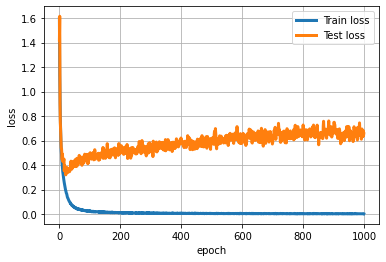

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(epoch+1),tr_loss,'-',linewidth=3,label='Train loss')
plt.plot(range(epoch+1),ts_loss,'-',linewidth=3,label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

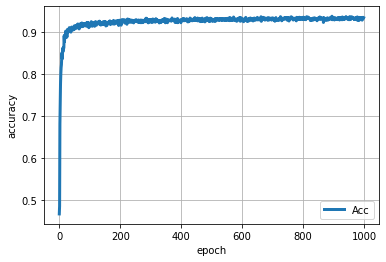

In [ ]:
plt.plot(range(epoch+1),np.array(torch.tensor(acc_list, device='cpu')),'-',linewidth=3,label='Acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

## Model Test

In [ ]:
def model_test(net):
  net.eval()
  test_loss = 0
  acc_num = 0
  for i, (X_ts, y_ts) in enumerate(testloader):

    X_ts, y_ts = X_ts.to(device), y_ts.to(device)
    y_ts_hat = net(X_ts)
    l_ts = loss(y_ts_hat, y_ts)
    test_loss += l_ts.item()
      
    y_pred = torch.argmax(y_ts_hat,axis=1)
    acc_num += torch.sum(y_pred == y_ts)

  acc = acc_num/len(test_data)
  return np.array(acc.clone().detach().cpu())

In [ ]:
import re
import os

path = "/content/drive/MyDrive/DL//project1/8482_bak" 
files= os.listdir(path)
lable_list = []
ep_list = []
best = 0 
for file in files:
  acc_lable = re.split('_|.pt',file)[2]
  ep_lable = re.findall('(?<=epoch)\d+',file)
  lable_list.append(acc_lable)
  ep_list.append(ep_lable)

max_idx = np.argmax(lable_list)

best_model = files[max_idx]
ep_num = int(np.array(ep_list[max_idx]))

best_path = path + "/" + best_model

net=torch.load(best_path)

best_acc = model_test(net)

print("The best accuracy after " + str(ep_num) + " epochs is " + str(best_acc))

The best accuracy after 895 epochs is 0.9377
